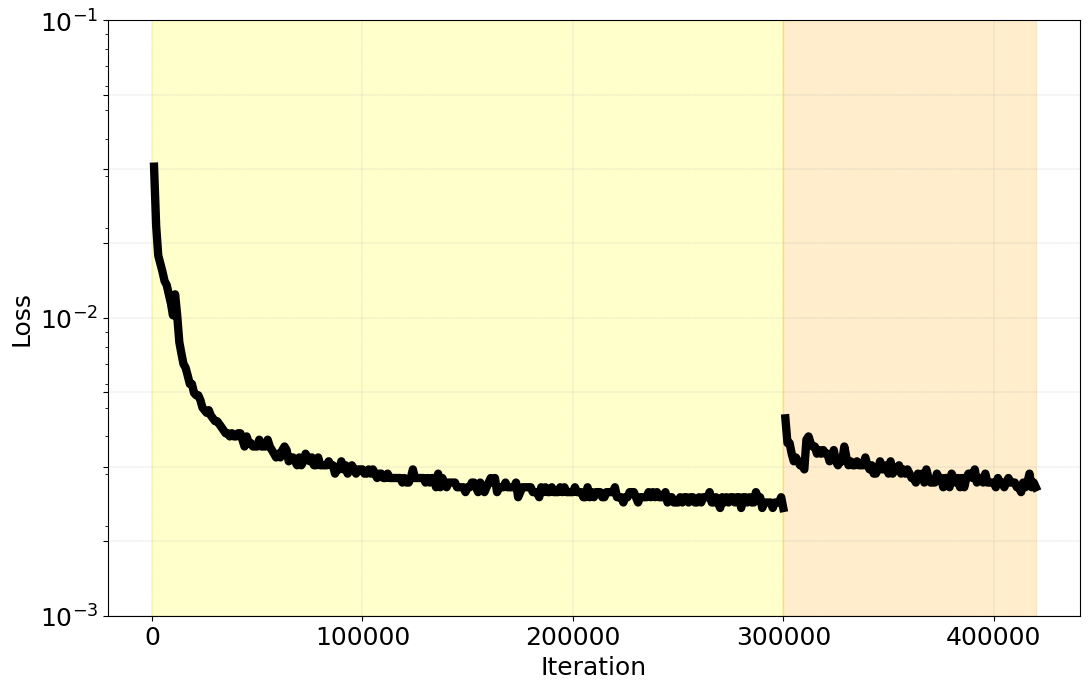

In [131]:
# Load the data from the provided file and prepare it for plotting.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
file_path = 'training_run_total.txt'

def parse_line(line):
    parts = line.split()
    iteration = int(parts[3])
    loss = float(parts[5])
    lr = float(parts[7])
    return iteration, loss, lr

# Open the file and parse it line by line
iterations = []
losses = []
lrs = []

with open(file_path, 'r') as file:
    for line in file:
        iteration, loss, lr = parse_line(line)
        iterations.append(iteration)
        losses.append(loss)
        lrs.append(lr)

# Convert lists to DataFrame
df = pd.DataFrame({
    'iteration': iterations,
    'loss': losses,
    'lr': lrs
})

# Highlight the division point at iteration 300000
division_iter = 300000

# Plotting the loss with a discontinuity at iteration 300000

plt.figure(figsize=(11, 7))

# Splitting the dataset into two parts for the discontinuity
df_first = df[df['iteration'] <= division_iter]
df_second = df[df['iteration'] > division_iter]

# Shading periods before and after the interruption point
plt.axvspan(0, division_iter, color='yellow', alpha=0.2)
plt.axvspan(division_iter, df['iteration'].max(), color='orange', alpha=0.2)

# Plotting both parts as continuous curves but with a gap between them
plt.plot(df_first['iteration'], df_first['loss'], color='black', linewidth=6)
plt.plot(df_second['iteration'], df_second['loss'], color='black', linewidth=6, label='Loss')

# Adding labels and adjusting the style
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.xticks(fontsize=18)

# Keeping y scale as log and removing gridlines
plt.yscale('log')

plt.yticks(10**np.linspace(-3, -1, num=9), fontsize=18)  # Adding more y-tick labels

plt.grid(True, linestyle='--', linewidth=0.25)

# Tight layout for neatness
plt.tight_layout()
plt.savefig('loss curve.pdf', bbox_inches='tight')
plt.show()

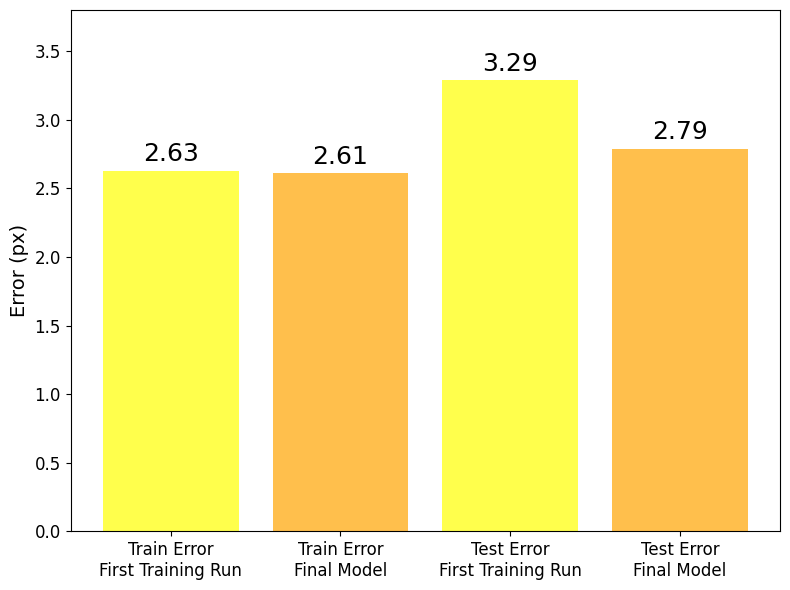

In [146]:
# Adjusting data labels
errors = {
    'Train Error\nFirst Training Run': 2.63,
    'Train Error\nFinal Model': 2.61,
    'Test Error\nFirst Training Run': 3.29,
    'Test Error\nFinal Model': 2.79
}

# Adjusting colors according to the iteration
colors_corrected = ['yellow', 'orange', 'yellow', 'orange']  # Correct colors for iteration

fig, ax = plt.subplots(figsize=(8, 6))

# Bar plot
bars = ax.bar(errors.keys(), errors.values(), color=colors_corrected, alpha=0.7)

plt.ylabel('Error (px)', fontsize=14)
plt.xticks(rotation=0, fontsize=12)  # No rotation for x-axis labels
plt.yticks(fontsize=12)
#plt.title('Train and Test Errors for First Iteration and Final Model', fontsize=16)

# Removing gridlines
plt.grid(False)
plt.ylim(2,3.5)
plt.ylim(0,3.8)

# Adding the y value above each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=18)

plt.tight_layout()
# Save the figure as a PDF
plt.savefig('train test errors.pdf', bbox_inches='tight')
plt.show()

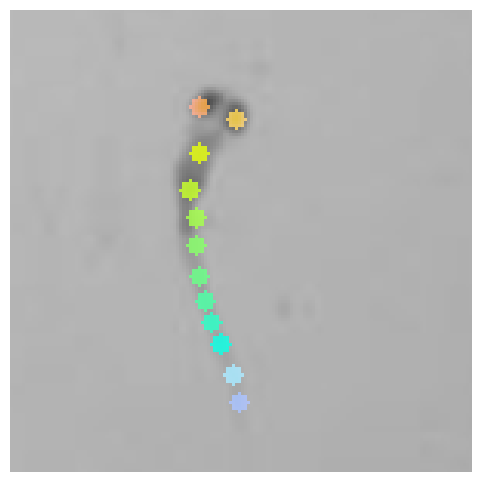

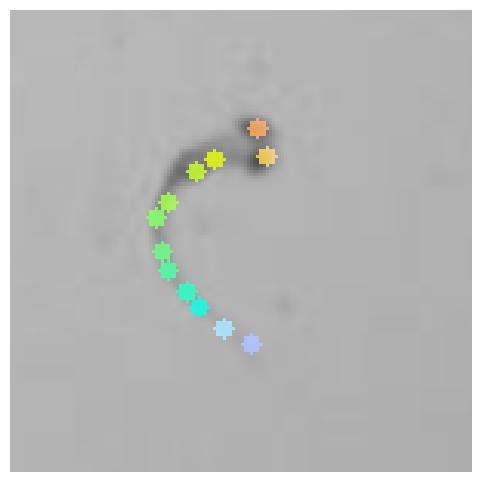

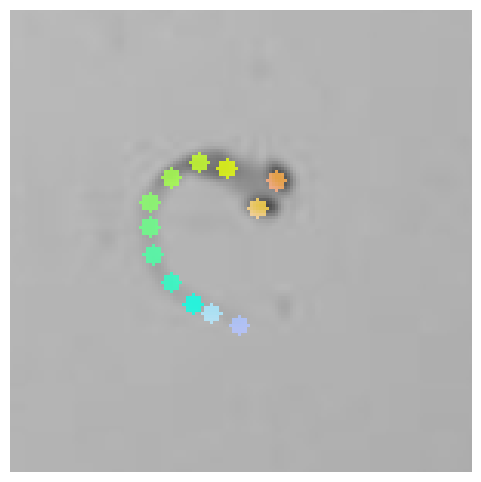

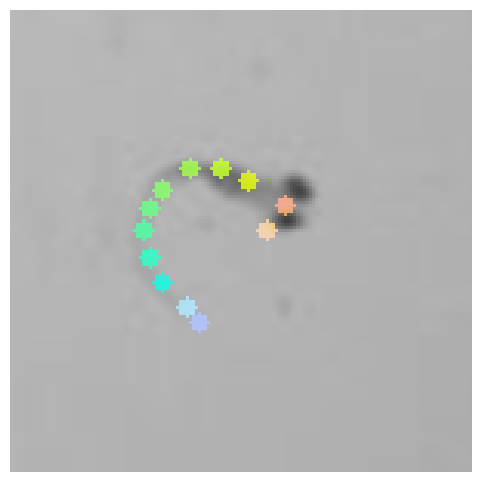

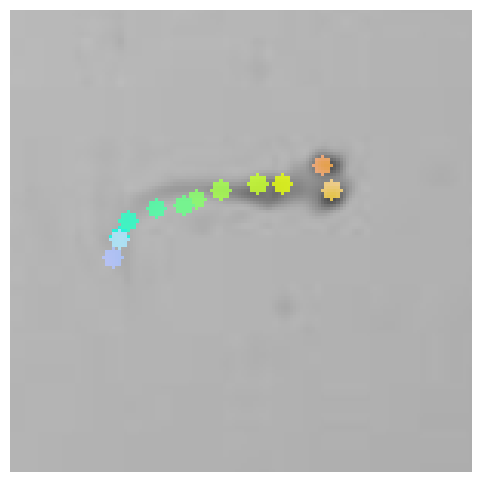

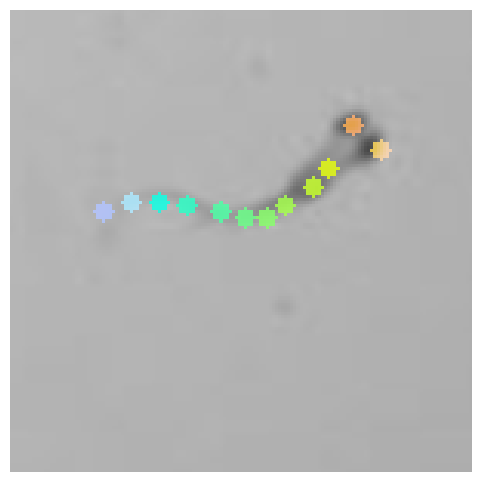

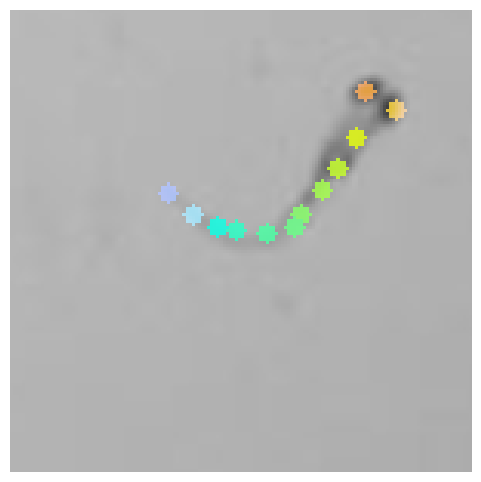

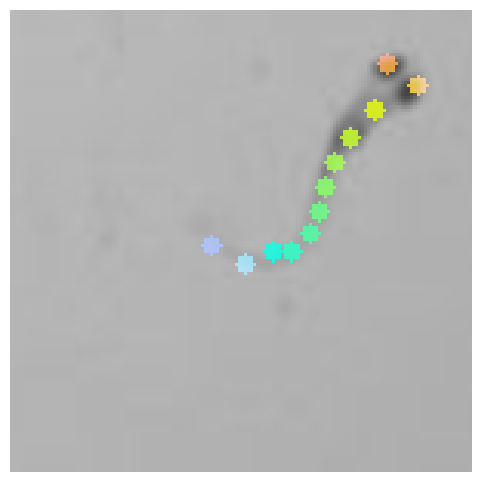

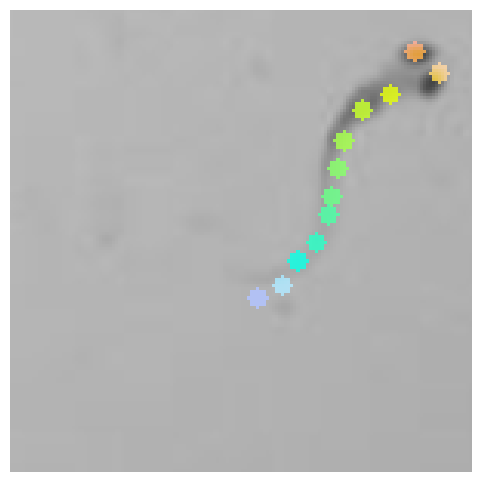

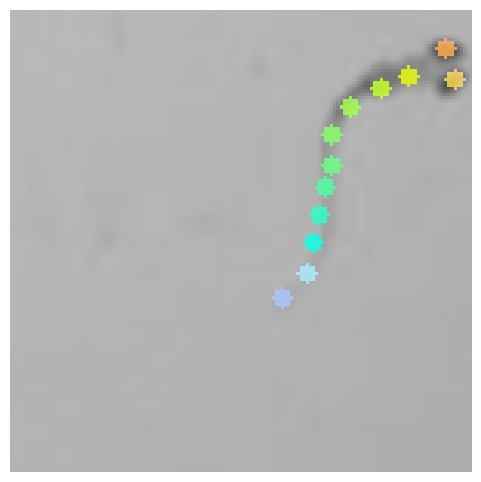

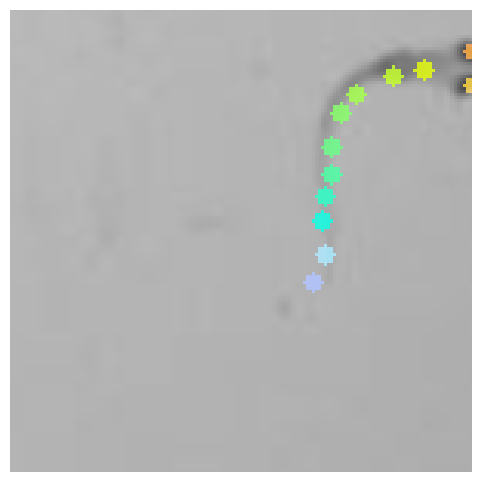

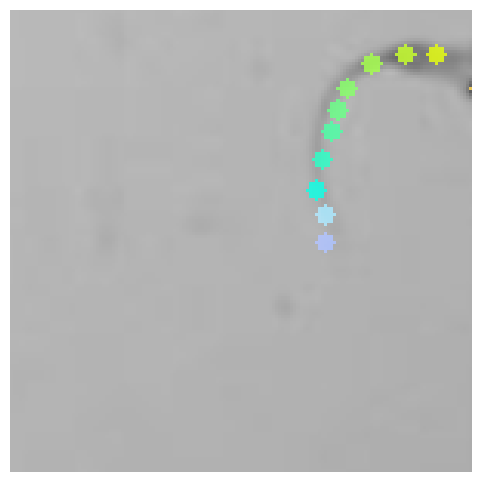

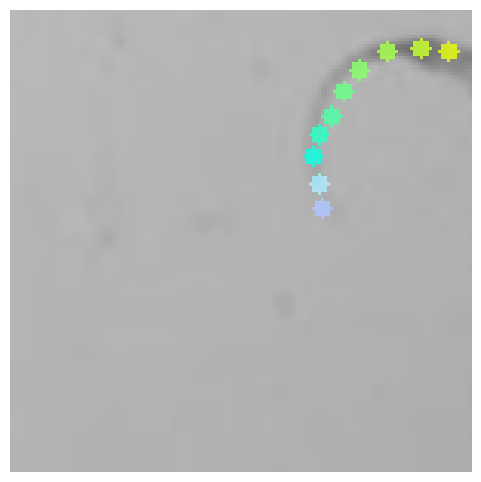

In [145]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Step 1: Read the CSV file and process column names
csv_file = 'confocallike3-02232024175459-0000DLC_resnet50_arena-cuadradaSep1shuffle1_420000.csv'
data = pd.read_csv(csv_file, header=None, skiprows=1)
# Combine the second and third rows to form the column names
col_names = data.iloc[0] + '_' + data.iloc[1]
data.columns = col_names
data = data.drop([0, 1])

# Drop the first column as it doesn't contain x/y/likelihood information
data = data.iloc[:, 1:]


fish_pos = (1030,450)
window_shape = (150,150)


# Step 2: Extract the 10,000th frame from the video
video_file = 'confocallike3-02232024175459-0000.avi'
cap = cv2.VideoCapture(video_file)
frame_numbers = np.arange(10517,10530)

for frame_number in frame_numbers:
    cap.set(1, frame_number - 1)  # Frame numbers are 0-based
    ret, frame = cap.read()

    if not ret:
        raise Exception("Failed to capture frame from the video.")

    # Convert frame to RGB (OpenCV uses BGR by default) and upscale the image
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    upscale_factor = 2  # Define the upscale factor (e.g., 2 times the original size)
    upscaled_frame_rgb = cv2.resize(frame_rgb, (frame_rgb.shape[1] * upscale_factor, frame_rgb.shape[0] * upscale_factor), interpolation=cv2.INTER_LINEAR)

    # Create a transparent overlay
    overlay = upscaled_frame_rgb.copy()
    overlay = np.zeros_like(upscaled_frame_rgb)

    frame_data = data.iloc[frame_number - 1]  # Adjusted for correct row offset
    points = [(frame_data[col], frame_data[col.replace('_x', '_y')]) for col in data.columns if col.endswith('_x')]

    colors = plt.cm.jet(np.linspace(0.3, 0.7, len(points)))

    for (x, y), color in zip(points, colors):
        x, y = float(x) * upscale_factor, float(y) * upscale_factor  # Adjust point positions for upscaled image
        # Convert color for OpenCV and adjust alpha value for 50% opacity
        color = tuple([int(c * 255) for c in color[:3]][::-1])
        cv2.circle(overlay, (int(x)+5, int(y)+5), 3, color=color, thickness=-1)

    # Blend the overlay with the upscaled frame using a specific opacity
    alpha = 0.85  # Define the opacity level (50% in this case)
    
    # Find non-zero (colored) pixels in the overlay (i.e., where the circles are drawn)
    mask = overlay > 0
    # For each channel (B, G, R), blend only the non-zero pixels
    for c in range(0, 3):
        upscaled_frame_rgb[:, :, c] = np.where(mask[:, :, c],
                                               (overlay[:, :, c] * alpha + upscaled_frame_rgb[:, :, c] * (1 - alpha)),
                                               upscaled_frame_rgb[:, :, c])

    
    upscaled_frame_rgb = upscaled_frame_rgb[fish_pos[1]-window_shape[1]//2 : fish_pos[1]+window_shape[1]//2, fish_pos[0]-window_shape[0]//2 : fish_pos[0]+window_shape[0]//2]
    
    # Step 4: Display the image
    plt.figure(figsize=(6,6))
    plt.imshow(upscaled_frame_rgb)
    plt.axis('off')  # Hide axis
    cv2.imwrite(f'event_frame_{frame_number}.jpg', cv2.cvtColor(upscaled_frame_rgb, cv2.COLOR_RGB2BGR))
    plt.show()
    
cap.release()

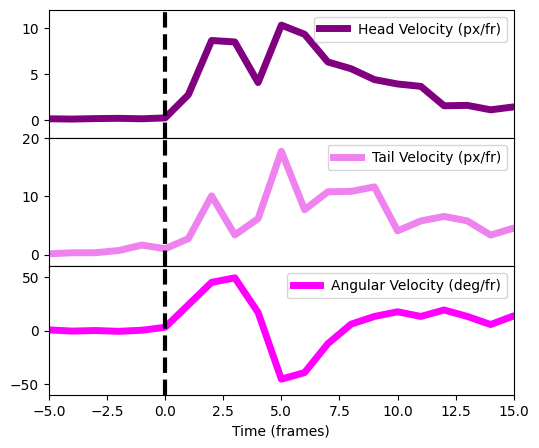

In [133]:
import numpy as np
import matplotlib.pyplot as plt

for col in data.columns:
    data[col] = pd.to_numeric(data[col])

# Calculate midpoint between eyes for each frame
eye_midpoint_x = (data['eyeL_x'] + data['eyeR_x']) / 2
eye_midpoint_y = (data['eyeL_y'] + data['eyeR_y']) / 2
midpoints = np.vstack((eye_midpoint_x, eye_midpoint_y)).T

# Calculate velocity of the midpoint (head velocity)
head_velocity = np.sqrt(np.sum(np.diff(midpoints, axis=0) ** 2, axis=1))

# Tail velocity (using the last tail point 'tail8')
tail_velocity = np.sqrt(np.diff(data['tail8_x'])**2 + np.diff(data['tail8_y'])**2)

# Angular velocity
angles = np.arctan2(eye_midpoint_y - data['vejigaP_y'], eye_midpoint_x - data['vejigaP_x'])
angular_velocity = np.diff(np.unwrap(angles))

# Curvature calculations for tail points
curvatures = []
for i in range(1, 7):  # Assuming tail points are numbered sequentially from 1 to 8
    p1 = data[[f'tail{i}_x', f'tail{i}_y']].to_numpy()
    p2 = data[[f'tail{i+1}_x', f'tail{i+1}_y']].to_numpy()
    p3 = data[[f'tail{i+2}_x', f'tail{i+2}_y']].to_numpy()
    ba = p1 - p2
    bc = p3 - p2
    curvature = np.abs(np.cross(ba, bc)) / (np.linalg.norm(ba) * np.linalg.norm(bc) * np.linalg.norm(ba - bc))
    curvatures.append(curvature)
average_curvature = np.nanmean(curvatures, axis=0)

# Likelihood of the last tail point
last_tail_likelihood = data['tail8_likelihood']

# Time or frame number (assuming continuous and complete frames)
time = np.arange(len(data))

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(6, 5), sharex=True)

# Define common styling
vline_style = {'color': 'black', 'linestyle': '--', 'linewidth': 3}

# Head velocity
axs[0].plot(time[:-1] - frame_numbers[0] + 3, head_velocity, color = 'purple', linewidth = 5)
axs[0].legend(['Head Velocity (px/fr)'])
axs[0].axvline(0, **vline_style)
axs[0].set_ylim(-2, 12)

# Tail velocity
axs[1].plot(time[:-1] - frame_numbers[0] + 3, tail_velocity, color = 'violet', linewidth = 5)
axs[1].legend(['Tail Velocity (px/fr)'])
axs[1].axvline(0, **vline_style)
axs[1].set_ylim(-2, 20)

# Angular velocity
axs[2].plot(time[:-1] - frame_numbers[0] + 3, angular_velocity/(2*np.pi)*360, color = 'magenta', linewidth = 5)
axs[2].legend(['Angular Velocity (deg/fr)'])
axs[2].axvline(0, **vline_style)
axs[2].set_ylim(-60, 60)

# Curvature
# axs[3].plot(time, average_curvature, **curve_style)
# axs[3].set_ylabel('Average Curvature Over Time')
# axs[3].axvline(frame_numbers[0]-3, **vline_style)

# # Last tail point likelihood
# axs[4].plot(time, last_tail_likelihood, **curve_style)
# axs[4].set_ylabel('Likelihood of Last Tail Point Over Time')
# axs[4].axvline(frame_numbers[0]-3, **vline_style)

# Set the x-axis limits for the last plot, which applies to all because of sharex=True
axs[2].set_xlim(-5, 15)
axs[2].set_xlabel("Time (frames)")
# Remove margins between subplots and adjust layout
plt.subplots_adjust(hspace=0.0)

# Save the figure as a PDF
plt.savefig('features_over_time.pdf', bbox_inches='tight')
plt.show()
